좋은 검증 데이터셋이란 아래와 같은 조건이 있습니다.
- 동일한 사람이 학습/검증 데이터에 모두 들어가있지않기
- 분포가 특정 클래스에 편향되어 있지않기

이를 해결하기 위해서 Stratified K-Fold를 이용해서 데이터셋을 정의해봅시다!

# 0. 라이브러리와 실험 세팅하기

In [1]:
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import *
from albumentations.pytorch import ToTensorV2


In [2]:
# 실험의 Randomness를 제거하여 실험이 같은 조건일 때 동일한 결과를 얻게 해줍니다.
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
    print(f'이 실험은 seed {seed}로 고정되었습니다.')

In [3]:
class conf:
    seed = 2021
    data_dir = '/opt/ml/input/data/train'
    n_fold = 5

seed_everything(conf.seed)

이 실험은 seed 2021로 고정되었습니다.


# 1. Dataset 전처리 함수 정의

In [4]:
def get_mask_label(image_name):
    """
    이미지 파일 이름을 통해 mask label을 구합니다.

    :param image_name: 학습 이미지 파일 이름
    :return: mask label
    """
    if 'incorrect' in image_name:
        return 1
    elif 'normal' in image_name:
        return 2
    elif 'mask' in image_name:
        return 0
    else:
        raise ValueError(f'No class for {image_name}')


def get_gender_label(gender):
    """
    gender label을 구하는 함수입니다.
    :param gender: `male` or `female`
    :return: gender label
    """
    return 0 if gender == 'm' else 1


def get_age_label(age):
    """
    age label을 구하는 함수입니다.
    :param age: 나이를 나타내는 int.
    :return: age label
    """
    return 0 if int(age) < 30 else 1 if int(age) < 60 else 2

In [5]:
def convert_gender_age(gender, age):
    """
    gender와 age label을 조합하여 고유한 레이블을 만듭니다.
    이를 구하는 이유는 train/val의 성별 및 연령 분포를 맞추기 위함입니다. (by Stratified K-Fold)
    :param gender: `male` or `female`
    :param age: 나이를 나타내는 int.
    :return: gender & age label을 조합한 레이블
    """
    gender_label = get_gender_label(gender)
    age_label = get_age_label(age)
    return gender_label * 3 + age_label


def convert_label(image_path, sep=False):
    """
    이미지의 label을 구하는 함수입니다.
    :param image_path: 이미지 경로를 나타내는 str
    :param sep: 마스크, 성별, 연령 label을 따로 반환할건지 합쳐서 할지 나타내는 bool 인수입니다. 참일 경우 따로 반환합니다.
    :return: 이미지의 label (int or list)
    """
    image_name = image_path.split('/')[-1]
    mask_label = get_mask_label(image_name)

    profile = image_path.split('/')[-2]
    image_id, gender, race, age = profile.split("_")
    gender_label = get_gender_label(gender)
    age_label = get_age_label(age)
    if sep:
        return mask_label, gender_label, age_label
    else:
        return mask_label * 6 + gender_label * 3 + age_label

In [6]:
IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]


def is_image_file(filepath):
    """
    해당 파일이 이미지 파일인지 확인합니다.
    """
    return any(filepath.endswith(extension) for extension in IMG_EXTENSIONS)


def remove_hidden_file(filepath):
    """
    `._`로 시작하는 숨김 파일일 경우 False를 반환합니다.
    """
    filename = filepath.split('/')[-1]
    return False if filename.startswith('._') else True

# 2. 데이터셋 함수 정의

In [7]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)


def get_transforms(need=('train', 'val'), img_size=(512, 384)):
    """
    Augmentation 함수를 반홥합니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            CenterCrop(448, 336, p=1.0),
            RandomResizedCrop(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.3),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.3),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.3),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.3),
            Cutout(p=0.3),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            CenterCrop(448, 336, p=1.0),
            Resize(img_size[0], img_size[1], p=1.0),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [8]:
def get_img(path):
    """
    이미지를 불러옵니다.
    """
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


class MaskDataset(Dataset):
    def __init__(self, image_dir, info, transform=None):
        self.image_dir = image_dir
        self.info = info
        self.transform = transform

        self.image_paths = [path for name in info.path.values for path in glob(os.path.join(image_dir, name, '*'))]
        self.image_paths = list(filter(is_image_file, self.image_paths))
        self.image_paths = list(filter(remove_hidden_file, self.image_paths))

        self.labels = [convert_label(path, sep=False) for path in self.image_paths]

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = get_img(image_path)

        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.eye(18)[label]
        return image, label

    def __len__(self):
        return len(self.image_paths)

# 3. 학습/검증 데이터셋 나누기

In [9]:
info = pd.read_csv(f'{conf.data_dir}/train.csv')
info.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [10]:
info['gender_age'] = info.apply(lambda x: convert_gender_age(x.gender, x.age), axis=1)

skf = StratifiedKFold(n_splits=conf.n_fold, shuffle=True)
info.loc[:, 'fold'] = 0
for fold_num, (train_index, val_index) in enumerate(skf.split(X=info.index, y=info.gender_age.values)):
    info.loc[info.iloc[val_index].index, 'fold'] = fold_num

## 3.1 학습/검증 데이터셋 분포확인

In [11]:
fold_idx = 0  # 현재 fold의 번호
train = info[info['fold'] != fold_idx]  # 학습 데이터셋 info
val = info[info['fold'] == fold_idx]    # 검증 데이터셋 info

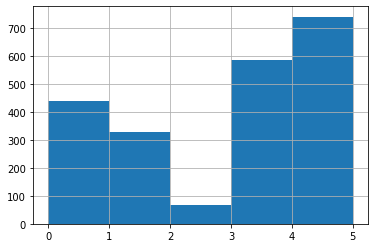

In [12]:
# 학습 데이터의 성별&연령 분포
train.gender_age.hist(bins=5)

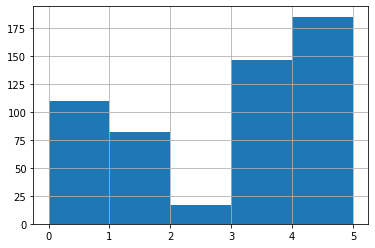

In [13]:
# 검증 데이터의 성별&연령 분포
val.gender_age.hist(bins=5)

- 학습 데이터와 검증 데이터의 성별과 연령이 동일한 분포를 가지고 있습니다.
- 모델의 성능을 측정하는데 검증 데이터가 신뢰가능합니다.
- 사람을 기준으로 나누었기때문에, 각 사람은 학습 또는 검증 데이터셋에만 속하고 둘 다에 모두 속할 수는 없습니다.

# 4. Pytorch 데이터셋을 Fold를 활용하여 정의하기

In [14]:
image_dir = os.path.join(conf.data_dir, 'images')

for fold_idx in range(conf.n_fold):
    train = info[info.fold != fold_idx].reset_index(drop=True)
    val = info[info.fold == fold_idx].reset_index(drop=True)

    transforms = get_transforms()
    train_dataset = MaskDataset(image_dir, train, transforms['train'])
    val_dataset = MaskDataset(image_dir, val, transforms['val'])
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                              num_workers=3)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                            num_workers=3)

읽어주셔서 감사합니다 :D